# Constant Product AMM modeling

In [11]:
import copy

In [94]:
# initial state

genesis = {
    "AMM":{"r1":100,"r2":100,"s":100,"fee":0.00},
    "Trader":{"r1":100,"r2":100,"s":0},
    "LP":{"r1":50,"r2":50,"s":100}
    }

In [35]:
genesis["AMM"]["r1"]

100

In [8]:
# Function to trade Asset 1 and receive Asset2

def swapToAsset2(state,inputs):
    agent = inputs[0]
    dA1 = inputs[1]
    feeFactor = (1-state["AMM"]["fee"])
    dA2 = state["AMM"]["r2"]/(state["AMM"]["r1"]+dA1*feeFactor)*dA1*feeFactor
    if dA1>0 and state[agent]["r1"]-dA1 >= 0 :
        state["AMM"]["r1"]+=dA1
        state[agent]["r1"]-=dA1
        state["AMM"]["r2"]-=dA2
        state[agent]["r2"]+=dA2

In [20]:
# Function to trade Asset 2 and receive Asset1

def swapToAsset1(state,inputs):
    agent = inputs[0]
    dA2 = inputs[1]
    feeFactor = (1-state["AMM"]["fee"])
    dA1 = state["AMM"]["r1"]/(state["AMM"]["r2"]+dA2*feeFactor)*dA2*feeFactor
    if dA2>0 and state[agent]["r2"]-dA2 >= 0 :
        state["AMM"]["r2"]+=dA2
        state[agent]["r2"]-=dA2
        state["AMM"]["r1"]-=dA1
        state[agent]["r1"]+=dA1 

In [28]:
# Liquidity Insertion

def addLiquidity(state,inputs):
    agent = inputs[0]
    R1 = state["AMM"]["r1"]
    R2 =state["AMM"]["r2"]
    S = state["AMM"]["s"]
    dA1 = min(inputs[1],R1/R2*inputs[2])
    dA2 = min(inputs[2],R2/R1*inputs[1])
    if (dA1 <= state[agent]["r1"] and dA2 <= state[agent]["r2"]) and (dA1 > 0 and dA2 > 0):
        state[agent]["r1"]-=dA1
        state[agent]["r2"]-=dA2
        state["AMM"]["r1"]+=dA1
        state["AMM"]["r2"]+=dA2
        dS = min(dA1/R1, dA2/R2) * S
        state["AMM"]["s"] += dS
        state[agent]["s"]+=dS

In [30]:
# Liquidity Removal

def removeLiquidity(state,inputs):
    dS = inputs[1]
    agent = inputs[0]
    if dS > 0 and state[agent]["s"]-dS>=0 and state["AMM"]["s"]-dS>=0:
        DR = (1-dS/state["AMM"]["s"])
        R1=state["AMM"]["r1"]
        R2=state["AMM"]["r2"]
        state[agent]["s"]-=dS
        state["AMM"]["r1"]=R1*DR
        state["AMM"]["r2"]=R2*DR
        state[agent]["r1"]+=R1-state["AMM"]["r1"]
        state[agent]["r2"]+=R2-state["AMM"]["r2"]
        state["AMM"]["s"]-=dS

In [52]:
# Testing the model above

# swapToAsset2(genesis,["Trader",10])

# genesis

addLiquidity(genesis,["LP", 10, 10])

B = copy.deepcopy(genesis)

removeLiquidity(genesis,["LP", 20])

C = copy.deepcopy(genesis)

B, C


({'AMM': {'r1': 110, 'r2': 110, 's': 110.0, 'fee': 0.0},
  'Trader': {'r1': 100, 'r2': 100, 's': 0},
  'LP': {'r1': 40, 'r2': 40, 's': 110.0}},
 {'AMM': {'r1': 90.0, 'r2': 90.0, 's': 90.0, 'fee': 0.0},
  'Trader': {'r1': 100, 'r2': 100, 's': 0},
  'LP': {'r1': 60.0, 'r2': 60.0, 's': 90.0}})

In [21]:
# AMM loses money due to rounding in reverting the state back

swapToAsset1(genesis,["Trader",9.0909090909091])

genesis

{'AMM': {'r1': 99.99999999999999, 'r2': 100.0, 's': 100, 'fee': 0.0},
 'Trader': {'r1': 100.00000000000001, 'r2': 100.0, 's': 0},
 'LP': {'r1': 0, 'r2': 0, 's': 100}}

In [53]:
# Nice print function that limits the display to 03 decimal points

def nice_print(self):
    if type(self)==float:
        return  round(self,3)
    if type(self)==int:
        return  self
    if type(self)==list:
        return  list(map(lambda l: print(l),self))
    if type(self)==dict:
        return  dict(map(lambda kv: (kv[0], print(kv[1])),self.items()))

In [54]:
actionList = [
        [ removeLiquidity , [  "LP" , 5 ]],
        [ removeLiquidity , [  "LP" , 5 ]],
        [ removeLiquidity , [  "LP" , 5 ]]]

In [55]:
def evolve(state, actionStack):
    history = [copy.deepcopy(state)]
    for action in actionStack:
        action[0](state,action[1])
        history.append(copy.deepcopy(state))
    return history

In [70]:
# testing evolve function. 02 consecutive trades

genesis = {
    "AMM":{"r1":100,"r2":100,"s":100,"fee":0.00},
    "Trader":{"r1":100,"r2":100,"s":0},
    "LP":{"r1":50,"r2":50,"s":100}
    }

actionList = [
    [swapToAsset2, ["Trader", 50]],
    [swapToAsset1, ["Trader", 25]]
]

states = evolve(genesis, actionList)

states
# Trader gets less asset2 in first trade -> slippage
# Trader gets more asset1 in second trade as price changed

[{'AMM': {'r1': 100, 'r2': 100, 's': 100, 'fee': 0.0},
  'Trader': {'r1': 100, 'r2': 100, 's': 0},
  'LP': {'r1': 50, 'r2': 50, 's': 100}},
 {'AMM': {'r1': 150, 'r2': 66.66666666666667, 's': 100, 'fee': 0.0},
  'Trader': {'r1': 50, 'r2': 133.33333333333331, 's': 0},
  'LP': {'r1': 50, 'r2': 50, 's': 100}},
 {'AMM': {'r1': 109.0909090909091,
   'r2': 91.66666666666667,
   's': 100,
   'fee': 0.0},
  'Trader': {'r1': 90.9090909090909, 'r2': 108.33333333333331, 's': 0},
  'LP': {'r1': 50, 'r2': 50, 's': 100}}]

In [81]:
#  function to check if all inputs are proper
def checkGenesisBlock(state):
   
#    ask Rohan

In [ ]:
# Testing if input check is working

checkGenesisBlock(genesis)

In [84]:
# function to update fee charged by AMM
def updatePoolFees(fee):
    genesis["AMM"]["fee"] = fee
    

In [95]:
updatePoolFees(0.05)

genesis["AMM"]["fee"]

0.05

In [92]:
# swapping asset1 to 2 with input in percentage of holding
def swapToAsset2_pct(state, inputs):
    input = inputs
    input[1] = state[inputs[0]]["r1"]*inputs[1]/100
    swapToAsset2(state,input)

In [96]:
# testing percentage input for trade
swapToAsset2_pct(genesis, ["Trader", 20])

genesis


{'AMM': {'r1': 120.0, 'r2': 84.03361344537815, 's': 100, 'fee': 0.05},
 'Trader': {'r1': 80.0, 'r2': 115.96638655462185, 's': 0},
 'LP': {'r1': 50, 'r2': 50, 's': 100}}

In [113]:
# discuss with Rohan

def fiatPrintHolding(state, agent, prices):
    valueOfToken1 = state[agent]["r1"]*prices["r1"]
    valueOfToken2 = state[agent]["r2"]*prices["r2"]
    holdingValue = valueOfToken1+valueOfToken2
    print(str(nice_print(holdingValue))+" "+ prices["currency"])
    

In [114]:
price = {
    "r1": 5,
    "r2": 3,
    "currency": "USD"
}

fiatPrintHolding(genesis, "Trader", price)

747.899 USD


### VERIFYING THE DIGITAL TWIN

In [116]:
# calculate invariant value for a state
def invariant(state):
    return state["AMM"]["r1"] * state["AMM"]["r2"]

#calculate total of asset1 held by AMM, trader & LP. This should remain constant 
def asset1(state):
    return state["AMM"]["r1"]+state["Trader"]["r1"]+state["LP"]["r1"]

#calculate total of asset2 held by AMM, trader & LP. This should remain constant 
def asset2(state):
    return state["AMM"]["r2"]+state["Trader"]["r2"]+state["LP"]["r2"]

In [119]:
# testing if the invariant remains constant

genesis = {
    "AMM":{"r1":100,"r2":100,"s":100,"fee":0.00},
    "Trader":{"r1":100,"r2":100,"s":0},
    "LP":{"r1":50,"r2":50,"s":100}
}

state = copy.deepcopy(genesis)

swapToAsset2(state, ["Trader", 9])

invariant(genesis)==invariant(state)

True

In [122]:
# testing that invariant changes if we have fees

state = copy.deepcopy(genesis)
state["AMM"]["fee"] = 0.01

swapToAsset1(state, ["Trader", 15])

invariant(genesis)==invariant(state)

False

In [124]:
# total number of tokens should remain constant

genesis = {
    "AMM":{"r1":100,"r2":100,"s":100,"fee":0.00},
    "Trader":{"r1":100,"r2":100,"s":0},
    "LP":{"r1":50,"r2":50,"s":100}
}

state = copy.deepcopy(genesis)

swapToAsset1(state, ["Trader", 22])

asset1(state) == asset1(genesis) and asset2(state) == asset2(genesis)

True

In [128]:
# testing with false input state. r2 manually reduced by 50

state = {
    "AMM":{"r1":100,"r2":100,"s":100,"fee":0.00},
    "Trader":{"r1":100,"r2":50,"s":0},
    "LP":{"r1":50,"r2":50,"s":100}
}

asset1(state) == asset1(genesis) and asset2(state) == asset2(genesis)

False

In [136]:
# state reverses back to orginal as trader reverses the first swap

genesis = {
    "AMM":{"r1":100,"r2":100,"s":100,"fee":0.00},
    "Trader":{"r1":100,"r2":100,"s":0},
    "LP":{"r1":50,"r2":50,"s":100}
}

state = copy.deepcopy(genesis)

swapToAsset1(state, ["Trader", 22])

gained = state["Trader"]["r1"] - genesis["Trader"]["r1"]

swapToAsset2(state,["Trader",gained])

genesis == state

True

In [138]:
# state reverses back to orginal as liquidity is added and then removed

genesis = {
    "AMM":{"r1":100,"r2":100,"s":100,"fee":0.00},
    "Trader":{"r1":100,"r2":100,"s":0},
    "LP":{"r1":50,"r2":50,"s":100}
}

state = copy.deepcopy(genesis)

addLiquidity(state, ["LP", 20, 20])

removeLiquidity(state, ["LP", 20])

genesis == state

True

In [145]:
%pip install matplotlib

import math
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 541.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 385.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 383.1 kB/s eta 0:00:0000:0100:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.4-cp39-cp39-macosx_11_0_arm64.whl (63 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 392.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 202.7 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


Text(0, 0.5, 'Asset 2')

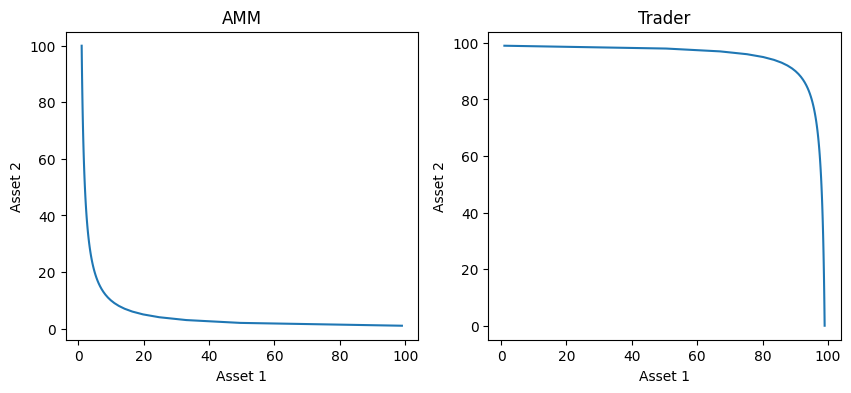

In [153]:
# multiple swap actions

genesis = {
    "AMM":{"r1":99,"r2":1,"s":math.sqrt(99),"fee":0.0},
    "Trader":{"r1":1,"r2":99,"s":0},
    "LP":{"r1":200,"r2":200,"s":math.sqrt(99)}
    }

actionList= [ [swapToAsset1,["Trader",1]] ] * 99

history = evolve(genesis, actionList)

AMM_r1=[]
Trader_r1=[]
AMM_r2=[]
Trader_r2=[]

for s in history:
    AMM_r1.append(s["AMM"]["r1"])
    Trader_r1.append(s["Trader"]["r1"])
    AMM_r2.append(s["AMM"]["r2"])
    Trader_r2.append(s["Trader"]["r2"])   


plt.figure(figsize=(10,4)) 
    
plt.subplot(1, 2, 1) 
plt.plot(AMM_r1,AMM_r2)
plt.title('AMM')
plt.xlabel("Asset 1")
plt.ylabel("Asset 2")

plt.subplot(1, 2, 2)
plt.plot(Trader_r1,Trader_r2)
plt.title('Trader')
plt.xlabel("Asset 1")
plt.ylabel("Asset 2")

Text(0, 0.5, 'Asset 2')

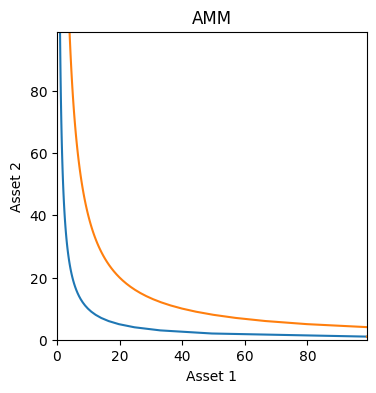

In [154]:
# effect of liquidity insertion

actionList.insert(0,[addLiquidity,["LP",100,100]])

genesis = {
    "AMM":{"r1":99,"r2":1,"s":math.sqrt(99),"fee":0.0},
    "Trader":{"r1":1,"r2":99,"s":0},
    "LP":{"r1":200,"r2":200,"s":math.sqrt(99)}
    }

history = evolve(genesis, actionList)

AMM_2r1=[]
Trader_2r1=[]
AMM_2r2=[]
Trader_2r2=[]

for s in history:
    AMM_2r1.append(s["AMM"]["r1"])
    Trader_2r1.append(s["Trader"]["r1"])
    AMM_2r2.append(s["AMM"]["r2"])
    Trader_2r2.append(s["Trader"]["r2"])   
    
plt.figure(figsize=(4,4)) 
plt.plot(AMM_r1,AMM_r2)
plt.plot(AMM_2r1,AMM_2r2)
plt.title('AMM')
plt.xlim([0, 99])
plt.ylim([0, 99])
plt.xlabel("Asset 1")
plt.ylabel("Asset 2")

In [164]:


def WF():
    input = range(1, 1001)
    output = 0;
    for x in input:
        if(x % 2 == 0):
            output+= math.ceil(math.sqrt(x))
        else:
            output+= x*x
    return output
        
            

In [165]:
result = WF()

In [166]:
result

166677300

In [174]:
actionList = [ 
    [ removeLiquidity , [ "LP" , 5 ]],
    [ removeLiquidity , [ "LP" , 10 ]],
    [ removeLiquidity , [ "LP" , 5 ]]
]



actionList[1][1]
              

['LP', 10]

In [181]:
def swapToAssetB(state,inputs):
    agent = inputs[0]
    dA1 = inputs[1]
    feeFactor = (1-state["AMM"]["fee"])
    dA2 = state["AMM"]["r2"]/(state["AMM"]["r1"]+dA1*feeFactor)*dA1*feeFactor
    state["AMM"]["r1"]+=dA1
    state[agent]["r1"]-=dA1
    state["AMM"]["r2"]-=dA2
    state[agent]["r2"]+=dA2

        
def swapToAssetA(state,inputs):
    agent = inputs[0]
    dA2 = inputs[1]
    dA1 = dA2
    
    state["AMM"]["r2"]+=dA2
    state[agent]["r2"]-=dA2
    state["AMM"]["r1"]-=dA1
    state[agent]["r1"]+=dA1        

In [191]:
start = {
    "AMM":{"r1":400,"r2":400,"s":100,"fee":0.00},
    "Trader":{"r1":10000,"r2":10000,"s":0},
    "LP":{"r1":50,"r2":50,"s":100}
    }

# swapToAssetB(start, ["Trader", 20])
# swapToAssetA(start, ["Trader", 20])
# swapToAssetB(start, ["Trader", 20])
# swapToAssetA(start, ["Trader", 20])

# start

actionList = [
    [swapToAssetB, ["Trader", 20]],
    [swapToAssetA, ["Trader", 20]]
]*300

newStates = evolve(start, actionList)

newStates[600]

{'AMM': {'r1': 400, 'r2': 419.9999912049102, 's': 100, 'fee': 0.0},
 'Trader': {'r1': 10000, 'r2': 9980.000008795088, 's': 0},
 'LP': {'r1': 50, 'r2': 50, 's': 100}}